### Topic 7 Analysis of Variance and Linear Models

In this assignment, a statistical analysis using analysis of variance (ANOVA) and linear models will be completed in Python. By working with a real-world dataset, students will apply ANOVA to examine differences in means across categorical variables and build linear models to predict the dependent variable. Then, assess the assumptions and limitations of ANOVA and linear models, proposing and implementing solutions to address these limitations, to improve the validity and accuracy analyses.



In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.compat import lzip
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson 
from sklearn.linear_model import LinearRegression
from scipy.stats import f
from sklearn.model_selection import train_test_split

C:\Users\jdgarc17\anaconda3\envs\TestEnv\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Task 1:

Research and find a dataset with one or more categorical variables and apply ANOVA to determine if there is a significant difference in the mean of the dependent variable across different levels of the categorical variable. Interpret the results and provide a detailed report with appropriate visualizations.

##### Data import and exploration

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Looking at this dataset the charges feature will be our dependent variable and there are multiple other features that we can use as categorical such as smoker or region.

##### investigate and remove outliers

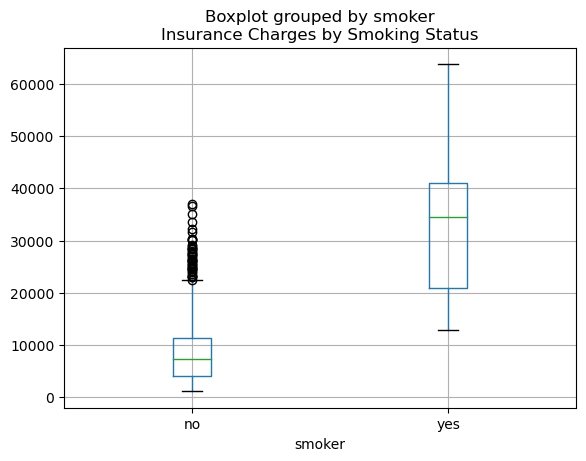

In [5]:
df.boxplot(column ='charges', by= 'smoker')
plt.title('Insurance Charges by Smoking Status')
plt.show()

In [6]:
#remove outliers grouped by smoking status
#calculate quantiles for each group
low = 0.05
high = 0.95
res = df.groupby('smoker')['charges'].quantile([low, high]).unstack(level=1)

# Filter rows within the quantile range
df = df[((res.loc[df['smoker'], low] < df['charges'].values) &
                  (df['charges'].values < res.loc[df['smoker'], high])).values]

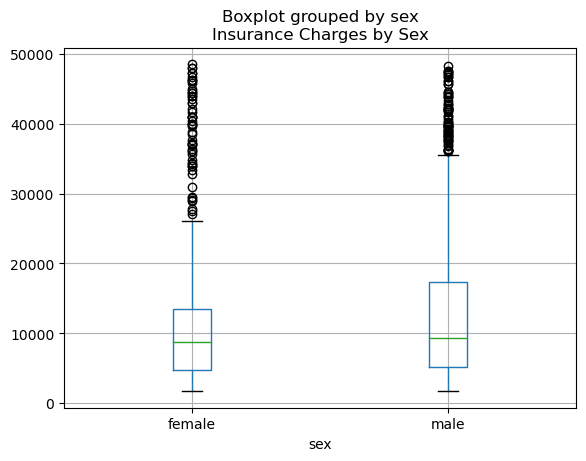

In [7]:
df.boxplot(column ='charges', by= 'sex')
plt.title('Insurance Charges by Sex')
plt.show()

In [8]:
#remove outliers grouped by sex
res = df.groupby('sex')['charges'].quantile([low, high]).unstack(level=1)

# Filter rows within the quantile range
df = df[((res.loc[df['sex'], low] < df['charges'].values) &
                  (df['charges'].values < res.loc[df['sex'], high])).values]

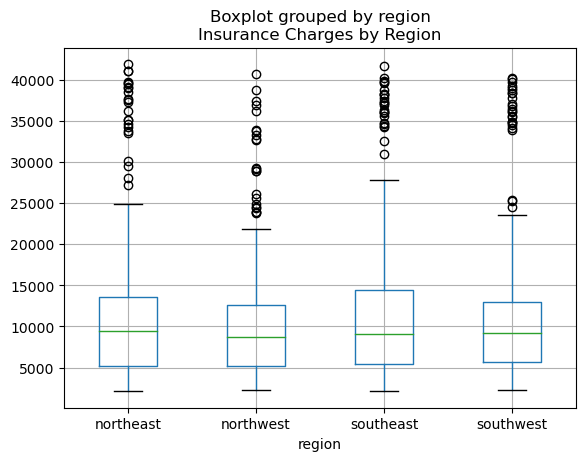

In [9]:
df.boxplot(column ='charges', by= 'region')
plt.title('Insurance Charges by Region')
plt.show()

In [10]:
#remove outliers grouped by region
res = df.groupby('region')['charges'].quantile([low, high]).unstack(level=1)

# Filter rows within the quantile range
df = df[((res.loc[df['region'], low] < df['charges'].values) &
                  (df['charges'].values < res.loc[df['region'], high])).values]

##### Investigate means of categorical features

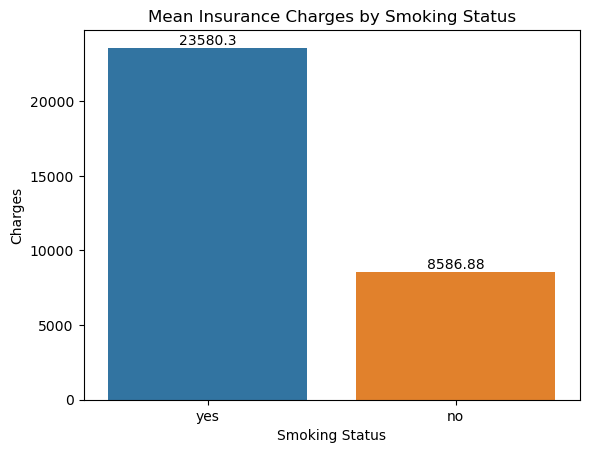

In [11]:
#plot means smoker groups
ax = sns.barplot(data=df, x='smoker', y='charges', hue='smoker',
                 estimator = 'mean', errorbar=None)
ax.set_xlabel('Smoking Status')
ax.set_ylabel('Charges')
ax.set_title('Mean Insurance Charges by Smoking Status')
for i in ax.containers:
    ax.bar_label(i,)

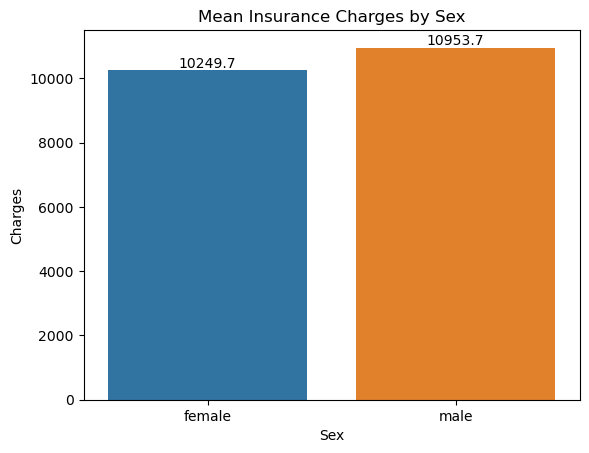

In [12]:
#plot means sex groups
ax = sns.barplot(data=df, x='sex', y='charges', hue='sex',
                 estimator = 'mean', errorbar=None)
ax.set_xlabel('Sex')
ax.set_ylabel('Charges')
ax.set_title('Mean Insurance Charges by Sex')
for i in ax.containers:
    ax.bar_label(i,)

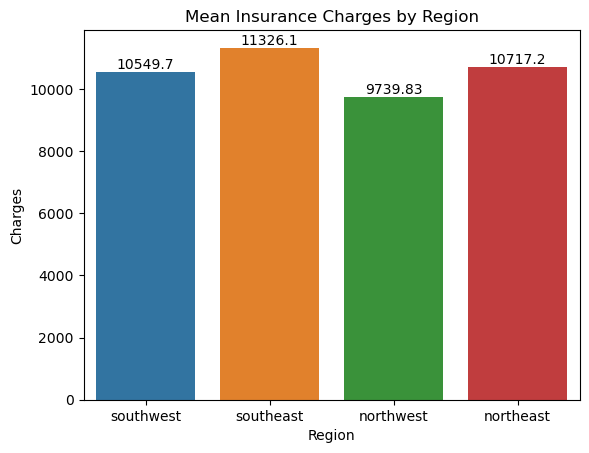

In [13]:
#plot means on region
ax = sns.barplot(data=df, x='region', y='charges', hue='region',
                 estimator = 'mean', errorbar=None)
ax.set_xlabel('Region')
ax.set_ylabel('Charges')
ax.set_title('Mean Insurance Charges by Region')
for i in ax.containers:
    ax.bar_label(i,)

Comparing mean insurance charges on different categorical variables we can see that it is highly likely there is a real significant difference between smoking status means. For our analysis it makes more since to further investigate if there is a link between differences in insurance means and region or sex. To further narrow down, let's see which of these meet assumptions of normality and equal variance among groups. 

To test normality we can use a qq plot and shapiro wilks test. To test equal variance we can use a levene test.

##### Test assumptions of categorical features

ShapiroResult(statistic=0.864412248134613, pvalue=4.193522268321198e-28)


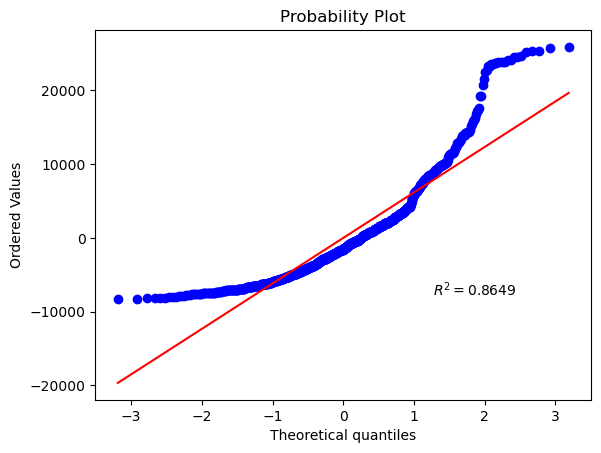

In [14]:
#Sex categorical feature assumption testing 

#use stats model to create a model that we can check assumptions on
model_sex = ols("charges ~ C(sex)", data=df).fit()

#use model to perform shapiro-wilk test on residuals
sex_shapiro = stats.shapiro(model_sex.resid)

#Create QQplot to visualize normality in the dataset
normality_splot, sstat = stats.probplot(model_sex.resid,plot=plt, rvalue= True)

print(sex_shapiro)

With the shapiro wilk test and qq plot we can see that the sex category does not meet the normality assumption. 

ShapiroResult(statistic=0.8685229420661926, pvalue=9.675916336990194e-28)


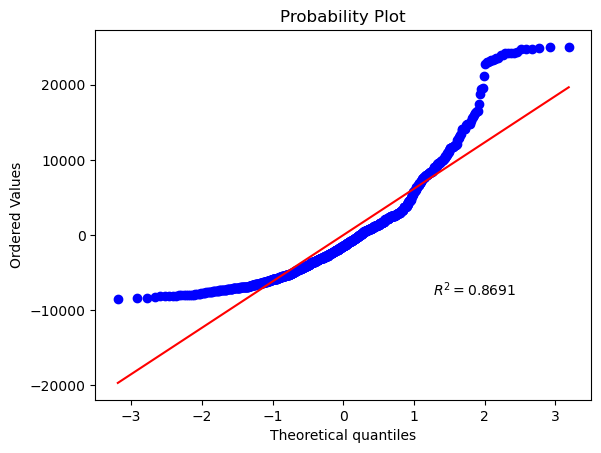

In [15]:
#Region categorical feature assumption testing 

#use stats model to create a model that we can check assumptions on
model_region= ols("charges ~ C(region)", data=df).fit()

#use model to perform shapiro-wilk test on residuals
region_shapiro = stats.shapiro(model_region.resid)

#Create QQplot to visualize normality in the dataset
normality_rplot, rstat = stats.probplot(model_region.resid,plot=plt, rvalue= True)

print(region_shapiro)

The region categorical data also fails to meet the assumption of normality in the dataset. Going forward we will have to use a non-parametric ANOVA test that does not assume normality for our testing. 

In [16]:
# equal variance testing for sex category

#break categories in groups
female = df['charges'].loc[df['sex']=='female']
male = df['charges'].loc[df['sex']=='male']

#use scipy.stats to run levene test
stats.levene(female,male)

LeveneResult(statistic=1.8347761120496529, pvalue=0.17588118047119544)

In [17]:
# equal variance testing for region category

#break categories in groups
southwest = df['charges'].loc[df['region']=='southwest']
southeast = df['charges'].loc[df['region']=='southeast']
northwest = df['charges'].loc[df['region']=='northwest']
northeast = df['charges'].loc[df['region']=='northeast']

#use scipy.stats to run levene test
stats.levene(southwest,southeast,northwest,northeast)

LeveneResult(statistic=2.8146409325760304, pvalue=0.03823022946715678)

Both categories past the assumption of equal variance likely due to the removal of outliers done in preprocessing of the data. The regions category barely passes the test. 

Performing a one way anova using kruskal wallis test is appropriate since it does not assume normality.

In [18]:
result = stats.kruskal(female, male)
 
# Print the result
print(result)

KruskalResult(statistic=0.9375412194331147, pvalue=0.3329109803076057)


In [19]:
result = stats.kruskal(southeast,southwest,northeast,northwest)
 
# Print the result
print(result)

KruskalResult(statistic=2.9008304325452627, pvalue=0.4071692464689477)


With ANOVA testing we are able to accept the null hypothesis that there is not a significant difference in means in either group tested. Both the sex category and regions category anova test did not meet a threshold of below 0.05 p-value so we cannot reject the null hypothesis. 

### Task 2:

Develop a linear model with one or more independent variables that predicts the dependent variable of the same dataset used in Task 1 above. Interpret the coefficients and evaluate the significance of the model using the F-test. Provide a detailed report with appropriate visualizations.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

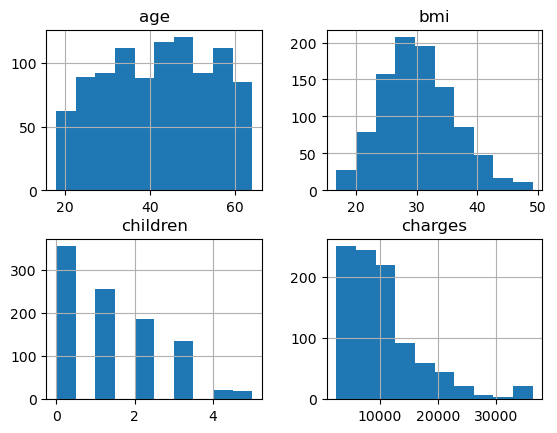

In [20]:
df.hist()

BMI is the variable that appears to have the possibility of following a normal distribution, so we can remove outliers and continue.

In [21]:
#calculate quantiles for each group
low = 0.05
high = 0.95
res = df.groupby('bmi')['charges'].quantile([low, high]).unstack(level=1)

# Filter rows within the quantile range
df = df[((res.loc[df['bmi'], low] < df['charges'].values) &
                  (df['charges'].values < res.loc[df['bmi'], high])).values]

ShapiroResult(statistic=0.9042166471481323, pvalue=2.436242527159571e-11)


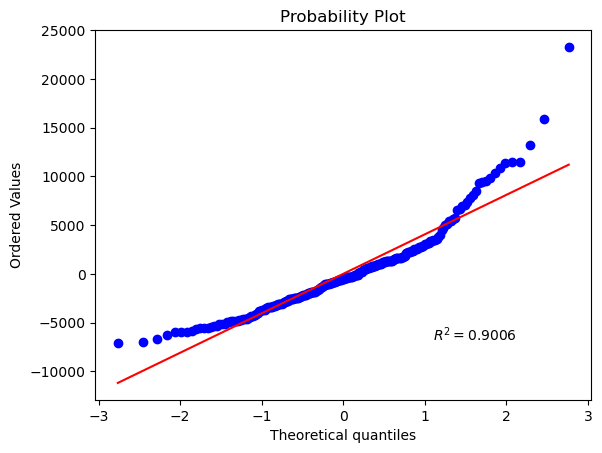

In [22]:
# run normality test
#Sex categorical feature assumption testing 

#use stats model to create a model that we can check assumptions on
model_lr = ols("charges ~ children", data=df).fit()

#use model to perform shapiro-wilk test on residuals
lr_shapiro = stats.shapiro(model_lr.resid)

#Create QQplot to visualize normality in the dataset
normality_plot, stat = stats.probplot(model_lr.resid,plot=plt, rvalue= True)

print(lr_shapiro)

<AxesSubplot:xlabel='bmi', ylabel='charges'>

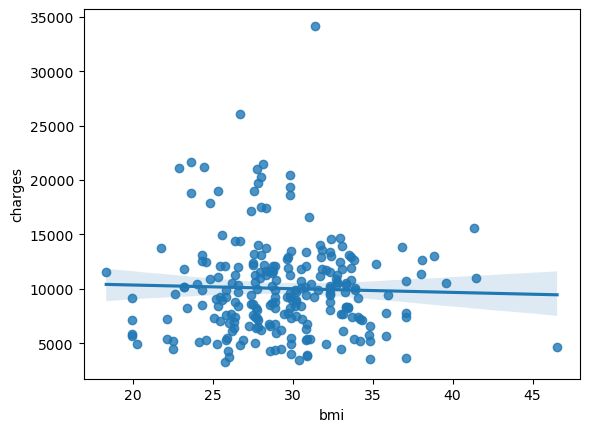

In [23]:
#test assumption that variable is linear
sns.regplot(data=df,x='bmi',y='charges')

Since there is not a linear relationship between our dependent and independent variable we will need to take the log of the dependent variable, or perform non-linear regression. For the purpose of this task, we will use the log method. 

In [24]:
#check for independence
#calculate residuals using ordinary least squares
model = ols('charges ~ bmi', data=df).fit()
durbin_watson(model.resid)

1.9306115696331207

This value is in the normal range(1.5-2.5), and should not affect our test. Thus, the assumption of independence between features is met. 

In [25]:
#test homoscedasticity with breusch pagan test
test = sms.het_breuschpagan(model.resid, model.model.exog)
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

lzip(names, test)

[('Lagrange multiplier statistic', 1.236678360184171),
 ('p-value', 0.2661121764266309),
 ('f-value', 1.2327737838099904),
 ('f p-value', 0.26797484997020304)]

The p-value fails to fall below the critical value, so we can accept the null hypothesis that there is no heteroscedasticity in the dataset.

In [26]:
#take log of dependent variable to adapt the non linear relationship
data_log = np.log10(df['charges'])

In [27]:
#create a model to perform linear regression
X = df['bmi'].values.reshape(-1, 1)
y = data_log.values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

8.274009344189093e-05

This model performs poorly even while meeting assumptions and correcting where assumptions are not met. The R^2 score produced by this code defines a more accurate model the closer the data is to one, so we can see that the model is inaccurate.A model can be improved by using other forms of regression, or obtaining more data.

In [28]:
# Create the data for two groups
group1 = X
group2 = y
 
# Calculate the sample variances
variance1 = np.var(group1, ddof=1)
variance2 = np.var(group2, ddof=1)
 
# Calculate the F-statistic
f_value = variance1 / variance2
 
# Calculate the degrees of freedom
df1 = len(group1) - 1
df2 = len(group2) - 1
 
# Calculate the p-value
p_value = stats.f.cdf(f_value, df1, df2)
 
# Print the results
print('Degree of freedom 1:',df1)
print('Degree of freedom 2:',df2)
print("F-statistic:", f_value)
print("p-value:", p_value)

Degree of freedom 1: 242
Degree of freedom 2: 242
F-statistic: 535.2131323496336
p-value: 0.9999999999999999


The F-statistic measures the ratio of variances between two groups. Here it is extremely high at approximately 214889.74. The p-valueretrieved is 0.9999999999999999. This indicates strong evidence against the null hypothesis, suggesting that there is likely a significant difference between the groups being compared.

### Task 3:

Discuss the assumptions and limitations of ANOVA and linear models, and how these can affect the validity of the results. Propose possible solutions to address or mitigate these limitations and explain how these solutions can be implemented in Python.

Assumptions of ANOVA
- Equal variance among groups
- Normality
- Independence

Assumptions of Linear regression
- Homoscedasticity - constant variance errors
- Normality
- Independence
- Linear Relationship 
- No multicollinearity

Limitations of ANOVA
- May not accurately measure a single hypothesis well
- Sensitivity to outliers

Limitations of Linear regression
- More assumptions to meet than ANOVA
- Correlation of variables does not provide basis for causation

Python is a useful tool as it provides tools to test these assmuptions and navigate around data that does not meet the assumptions. The limitations of Anova and Linear regression can lead to erroneous assumptions and results if assumptions are not met. Both tests are limited in their respective part of analytics in that they likely will not be the only test needed to prove assumptions. 

### Task 4:

Create a mini project that combines ANOVA and linear models to make predictions and draw conclusions from the same dataset used in Task 1 above. The project should include the following:

A detailed description of the problem and the research question.
A detailed data analysis using ANOVA and linear models to address the research question.
A discussion of the limitations and assumptions of the models used and possible solutions to address them.
A conclusion that summarizes the findings and implications of the research question

In this task we will investigate the relationship of combined variables within this dataset to see if a successful prediction model can be created for predeiction on insurance charges. The research question proposed for this project is whether smoking status and children have a significant affect on insurance charges. I predict the smoker status variable will help to produce a better model, since it had such an impact on means as shown in task one. For this model we will use ANCOVA to cobine regression and anova methods. ANCOVA can give insight into one indpedent variable at a time without the impact of another. 

The assumptions for ANCOVA are the same as linear regression and anova. This includes the data having a normal distribution, equal variance, homoscdasticity, a linear relationship, and independence among variables. 

In [39]:
#calculate means for smoking status and number of children
df.groupby(['smoker', 'children'])['charges'].mean()

smoker  children
no      0           10780.584175
        1            8349.746105
        2            8291.053013
        3            9098.783291
        4            9954.879362
        5            8010.930300
yes     0           21285.300729
        1           20631.418663
        2           20351.714217
        3           18765.875450
        4           21472.478800
Name: charges, dtype: float64

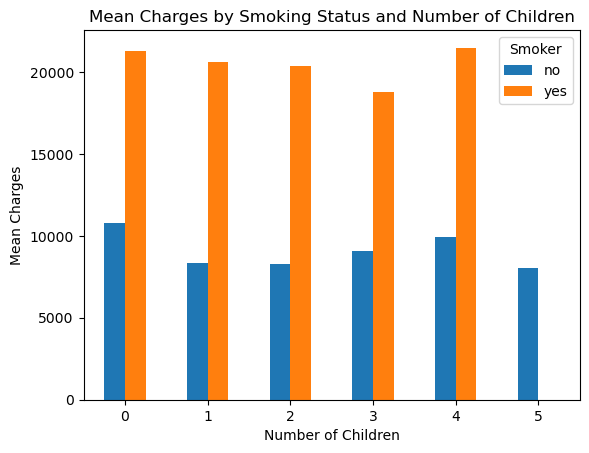

In [38]:
#create plot to visualize means for smoking and bmi
means = df.groupby(['smoker', 'children'])['charges'].mean()

# Convert the result to a DataFrame to easily manipulate the data
means_df = means.reset_index()

# Create a pivot table to reshape the data for plotting
pivot_means = means_df.pivot(index='children', columns='smoker', values='charges')

# Plotting the pivot table
pivot_means.plot(kind='bar')
plt.xlabel('Number of Children')
plt.ylabel('Mean Charges')
plt.title('Mean Charges by Smoking Status and Number of Children')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Smoker')
plt.show()

In [56]:
#check for independence
#calculate residuals using ordinary least squares
model = ols('charges ~ C(smoker) + children', data=df).fit()
durbin_watson(model.resid)

1.8718327464078774

The model shows independence in the data set for variables chosen.

In [57]:
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9715662598609924, pvalue=8.735228766454384e-05)

The data does not follow a normal distribution, so we will need to use a non-parametric test.

In [63]:
# equal variance testing for region category

#break categories in groups
smoke_yes_0_child = df['charges'].loc[(df['smoker'] == 'yes') & (df['children'] == 0)]
smoke_yes_1_child = df['charges'].loc[(df['smoker'] == 'yes') & (df['children'] == 1)]
smoke_yes_2_child = df['charges'].loc[(df['smoker'] == 'yes') & (df['children'] == 2)]
smoke_yes_3_child = df['charges'].loc[(df['smoker'] == 'yes') & (df['children'] == 3)]
smoke_yes_4_child = df['charges'].loc[(df['smoker'] == 'yes') & (df['children'] == 4)]
smoke_yes_5_child = df['charges'].loc[(df['smoker'] == 'yes') & (df['children'] == 5)]
smoke_no_0_child = df['charges'].loc[(df['smoker'] == 'no') & (df['children'] == 0)]
smoke_no_1_child = df['charges'].loc[(df['smoker'] == 'no') & (df['children'] == 1)]
smoke_no_2_child = df['charges'].loc[(df['smoker'] == 'no') & (df['children'] == 2)]
smoke_no_3_child = df['charges'].loc[(df['smoker'] == 'no') & (df['children'] == 3)]
smoke_no_4_child = df['charges'].loc[(df['smoker'] == 'no') & (df['children'] == 4)]

#use scipy.stats to run levene test
stats.levene(smoke_no_0_child,smoke_no_1_child,smoke_no_2_child,smoke_no_3_child,smoke_no_4_child,smoke_no_5_child,
            smoke_yes_0_child,smoke_yes_1_child,smoke_yes_2_child,smoke_yes_3_child,smoke_yes_4_child)

LeveneResult(statistic=1.0647556531796594, pvalue=0.3904616966575257)

The data follows the assumption of equal variance among groups.

In [31]:
#use ANCOVA to create a combined Anova and linear regression model 
from pingouin import ancova

In [52]:
#perform ANCOVA
ancova_result = ancova(data=df, dv='charges', covar='children', between='smoker')
ancova_result

,Source,SS,DF,F,p-unc,np2
0,smoker,1.934418e+09,1,192.532156,1.541954e-32,0.445128
1,children,9.352465e+07,1,9.308485,2.537218e-03,0.037337
2,Residual,2.411339e+09,240,NaN,NaN,NaN


The p value of the ancova model is well below the threshold of 0.05, which means we can reject the null hypothesis that smoking status and number of children means are not significantly different. The model predicts that the variance between groups for smoking is 192.53 in insurance charges, as shown with the F-Statistic. The model predicts tht the variance for insurance charges between number of children is 9.30 in insurance charges. 

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     103.5
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           3.87e-33
Time:                        22:12:42   Log-Likelihood:                -2302.2
No. Observations:                 243   AIC:                             4610.
Df Residuals:                     240   BIC:                             4621.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         9961.6800    308.554     32.285      0.000    9353.861    1.06e+04
C(smoker)[T.yes]  1.139e+04    821.080     13.876      0.000    9775.527     1.3e+04
children          -521.0658    170.786     -3.051      0.003    -857.497    -184.634
==============================================================================
Omnibus:                       23.313   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.047
Skew:                           0.652   Prob(JB):                     1.81e-07
Kurtosis:                       4.168   Cond. No.                         7.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
from scipy.stats import mannwhitneyu
mannwhitneyu(X,y)

MannwhitneyuResult(statistic=array([0.]), pvalue=array([4.30415946e-81]))

The mann whitney test was performed on the variable to evaluate non-parametric data with two independent variables. With this model, the null hypothesis is once again rejected in favor for these means having a statistically significant difference. 

References
Garcia, J. (2023, March 2024). Topoc 7 discussion question 2 [DSC 510]. Advanced Probability and Statistics. https://halo.gcu.edu/courses/DSC-510-O500-20240215/forums/discussion/87d0a902-82af-433a-b66d-fce8375a2b12